In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))

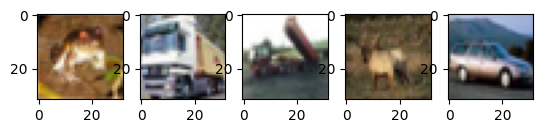

In [ ]:
import matplotlib.pyplot as plt
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
    plt.show()

plotn(5,x_train)

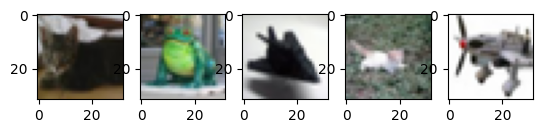

In [ ]:
def plotidx(indices, x):
    fig, ax = plt.subplots(1, len(indices))
    for i, z in enumerate(x[indices]):
        ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
    plt.show()

indices = [9, 19, 29, 39 , 49]
plotidx(indices,x_train)

# Denoising

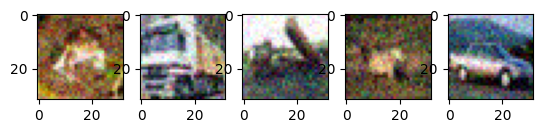

In [ ]:
def noisify(data):
    noise = np.random.normal(loc = 0.0, scale = 0.3, size = data.shape)
    data = data + noise * 0.3
    data = np.clip(data, 0., 1.)
    return data

x_train_noise = noisify(x_train)
x_test_noise = noisify(x_test)

plotn(5,x_train_noise)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, BatchNormalization, Activation
from tensorflow.keras.losses import binary_crossentropy, mse

def conv_block(x, filters, kernel_size, strides, activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x

def upsample_block(x, filters, kernel_size, strides, activation='relu', padding='same'):
    x = UpSampling2D()(x)
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x

input_img = Input(shape=(32, 32, 3))  # CIFAR-10 images: 32x32 RGB

# Encoder
x = conv_block(input_img, 64, (3, 3), strides=(1, 1))
x = conv_block(x, 64, (3, 3), strides=(1, 1))
x = MaxPooling2D((2, 2))(x)
x = conv_block(x, 128, (3, 3), strides=(1, 1))
x = conv_block(x, 128, (3, 3), strides=(1, 1))
x = MaxPooling2D((2, 2))(x)
x = conv_block(x, 256, (3, 3), strides=(1, 1))
x = conv_block(x, 256, (3, 3), strides=(1, 1))
encoded = MaxPooling2D((2, 2))(x)

# Decoder
x = upsample_block(encoded, 256, (3, 3), strides=(1, 1))
x = conv_block(x, 256, (3, 3), strides=(1, 1))
x = upsample_block(x, 128, (3, 3), strides=(1, 1))
x = conv_block(x, 128, (3, 3), strides=(1, 1))
x = upsample_block(x, 64, (3, 3), strides=(1, 1))
x = conv_block(x, 64, (3, 3), strides=(1, 1))
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

denoise_autoencoder = Model(input_img, decoded)
denoise_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
history = denoise_autoencoder.fit(x_train_noise, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

Epoch 1/25
391/391 [==============================] - 49s 93ms/step - loss: 0.5735 - val_loss: 0.5943
Epoch 2/25
391/391 [==============================] - 33s 85ms/step - loss: 0.5599 - val_loss: 0.5713
Epoch 3/25
391/391 [==============================] - 33s 84ms/step - loss: 0.5579 - val_loss: 0.5630
Epoch 4/25
391/391 [==============================] - 33s 84ms/step - loss: 0.5567 - val_loss: 0.5769
Epoch 5/25
391/391 [==============================] - 33s 85ms/step - loss: 0.5556 - val_loss: 0.5976
Epoch 6/25
391/391 [==============================] - 33s 84ms/step - loss: 0.5551 - val_loss: 0.5604
Epoch 7/25
391/391 [==============================] - 33s 84ms/step - loss: 0.5548 - val_loss: 0.5988
Epoch 8/25
391/391 [==============================] - 33s 84ms/step - loss: 0.5543 - val_loss: 0.5571
Epoch 9/25
391/391 [==============================] - 33s 85ms/step - loss: 0.5541 - val_loss: 0.5598
Epoch 10/25
391/391 [==============================] - 33s 83ms/step - loss: 0.553

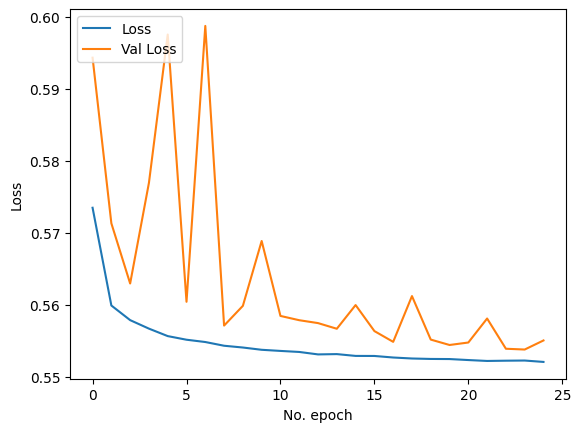

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

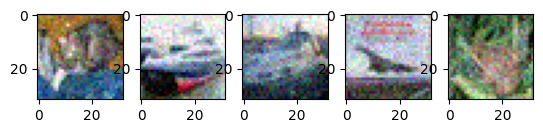

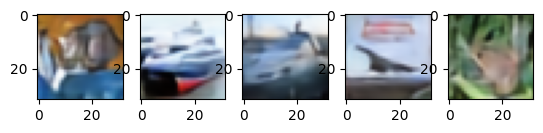

In [ ]:
y_test = denoise_autoencoder.predict(x_test_noise[0:5], verbose=False)
plotn(5,x_test_noise)
plotn(5,y_test)

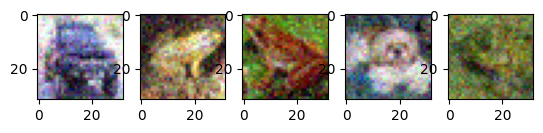

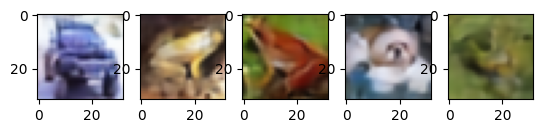

In [ ]:
y_test = denoise_autoencoder.predict(x_test_noise[indices], verbose=False)
plotidx(indices,x_test_noise)
plotn(5,y_test)

# Super-resolution

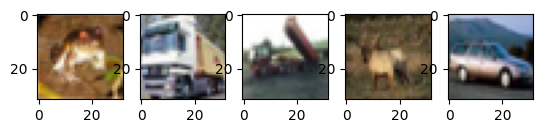

In [ ]:
plotn(5, x_train)

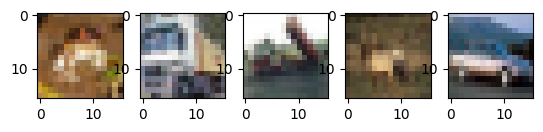

In [ ]:
import tensorflow as tf
x_train_lr = tf.keras.layers.AveragePooling2D()(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D()(x_test).numpy()
plotn(5, x_train_lr)

In [ ]:
def upsample_block(x, filters, kernel_size, padding='same'):
    x = UpSampling2D()(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

input_img = Input(shape=(16, 16, 3))  # Assuming input images are downsampled to 16x16

# Encoder (simplified since the input is already low-resolution)
x = conv_block(input_img, 32, (3, 3), strides=(1, 1))
x = conv_block(x, 64, (3, 3), strides=(1, 1))
encoded = MaxPooling2D((2, 2))(x)  # Downsampling here for learning robust features

# Decoder (focus on upscaling)
x = upsample_block(encoded, 64, (3, 3))
x = upsample_block(x, 32, (3, 3))
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output the high-resolution image

super_res_autoencoder = Model(input_img, decoded)
super_res_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Model summary
super_res_autoencoder.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 batch_normalization_23 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_22 (Activation)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_24 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                         

In [ ]:
history_2 = super_res_autoencoder.fit(x_train_lr, x_train,
               epochs=25,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test_lr, x_test))

Epoch 1/25
391/391 [==============================] - 12s 20ms/step - loss: 0.5647 - val_loss: 0.5918
Epoch 2/25
391/391 [==============================] - 7s 17ms/step - loss: 0.5577 - val_loss: 0.5575
Epoch 3/25
391/391 [==============================] - 7s 18ms/step - loss: 0.5566 - val_loss: 0.5565
Epoch 4/25
391/391 [==============================] - 7s 17ms/step - loss: 0.5558 - val_loss: 0.5567
Epoch 5/25
391/391 [==============================] - 7s 18ms/step - loss: 0.5553 - val_loss: 0.5574
Epoch 6/25
391/391 [==============================] - 7s 17ms/step - loss: 0.5550 - val_loss: 0.5554
Epoch 7/25
391/391 [==============================] - 7s 17ms/step - loss: 0.5548 - val_loss: 0.5554
Epoch 8/25
391/391 [==============================] - 7s 17ms/step - loss: 0.5545 - val_loss: 0.5560
Epoch 9/25
391/391 [==============================] - 6s 16ms/step - loss: 0.5543 - val_loss: 0.5561
Epoch 10/25
391/391 [==============================] - 7s 18ms/step - loss: 0.5541 - val_l

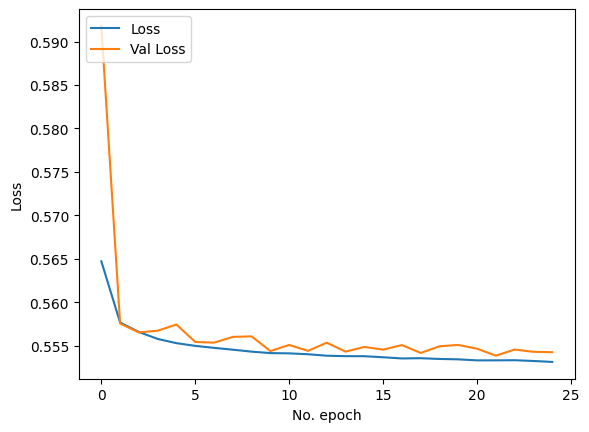

In [ ]:
plt.plot(history_2.history['loss'], label='Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

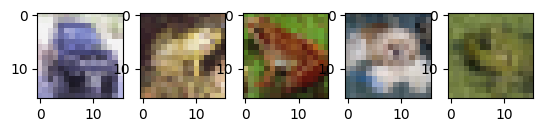

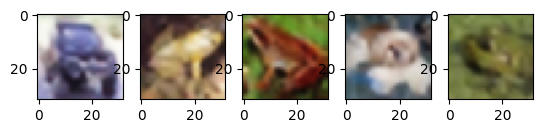

In [ ]:
y_test_lr = super_res_autoencoder.predict(x_test_lr[indices], verbose=False)
plotidx(indices, x_test_lr)
plotn(5, y_test_lr)